Trabajar en espacios de alta dimensionalidad puede ser... _molesto_. Por esto, se suele buscar reducir la dimensionalidad para:

* Visualizar los datos
* Reducir el espacio necesario para almacenar los datos (compresión)
* Reducir el costo computacional al entrenar algoritmos al reducir el número de features.
* Mejorar el funcionamiento de los modelos al incrementar el cociente señal/ruido y la densidad de puntos ( evitando la... *maldición de la dimensionalidad*).

Existen varios enfoques para reducir la dimensionalidad reteniendo la mayor cantidad de información posible. En particular, hay dos enfoques muy populares:
* Proyección: Proyectar el espacio altamente dimensional en un hiperplano de menor dimensionalidad, colapsando todas las variables ortogonales a él.
* Manifold-Learning: Aprender la geometría de un manifold de menor dimensión y proyectar la data a ese manifold.

Para la primer categoría, uno de los algoritmos más populares es el Análisis de Componentes Principales, o en _Principal Component Analysis_ (PCA).

In [1]:
# importamos las librerias necesarias
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import numpy as np
np.random.seed(42)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)


In [70]:
import numpy as np 
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente
from sklearn.decomposition import PCA

In [71]:
DATA_PATH = "../data"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "train_set_limpio.csv")
    return pd.read_csv(csv_path)


def load_data_test(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "test_set_limpio.csv")
    return pd.read_csv(csv_path)


In [72]:
train_set = load_data_prep()
test_set = load_data_test()
test_set.shape, train_set.shape

((13, 291), (52, 292))

In [73]:
test_set.loc[test_set.cod.str.contains('sub-500'),'label'] = '1'
test_set.loc[test_set.cod.str.contains('sub-10'),'label'] = '0'

In [74]:
test_set.shape, train_set.shape

((13, 292), (52, 292))

### Verificación de outliers

In [75]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 292 entries, cod to label
dtypes: float64(286), int64(5), object(1)
memory usage: 118.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Columns: 292 entries, cod to label
dtypes: float64(286), int64(4), object(2)
memory usage: 29.8+ KB


(None, None)

In [76]:
X_out = train_set.drop(['cod'], axis=1)
X_test_out = test_set.drop(['cod'], axis=1)


In [8]:
#!pip install -q pyod  

Reutilizo un código de: https://www.aprendemachinelearning.com/deteccion-de-outliers-en-python-anomalia/
La estrategia siguiente sirve para la detección de outliers: la media de la distribución más 2 sigmas como frontera. Pero existen otras  estrategias para delimitar outliers. 

In [77]:
from pyod.models.knn import KNN
import pandas as pd

clf = KNN(contamination=0.18)
clf.fit(X_out)
y_pred = clf.predict(X_out)
X_out[y_pred == 1]
clf.fit(X_test_out)
y_test = clf.predict(X_test_out)
X_test_out[y_test == 1]

,afsl_ad,afsl_area_of_end_region_1,afsl_area_of_end_region_2,afsl_branch_volume,afsl_curl,afsl_diameter,afsl_dti_fa,afsl_elongation,afsl_irregularity,afsl_irregularity_of_end_region_1,...,ufsr_radius_of_end_region_2,ufsr_rd,ufsr_rdi,ufsr_span,ufsr_total_area_of_end_regions,ufsr_total_radius_of_end_regions,ufsr_total_surface_area,ufsr_trunk_volume,ufsr_volume,label
0,1.23085,2493.23,1475.77,42.1074,2.57006,19.3913,0.410323,4.21650,7.42273,0.151082,...,8.31881,0.715491,0.150141,28.5609,4552.65,19.1203,40109.1,25846.0,26868.4,0
8,1.16005,1037.05,1824.39,17366.5000,3.53311,17.1555,0.414821,4.76362,8.63022,0.615759,...,7.54615,0.652482,0.180644,27.2461,2556.89,15.9317,22532.1,11870.8,13724.5,0


In [78]:
# borro los outliers
indicador = X_out[y_pred == 1].index
indicador_test = X_test_out[y_test == 1].index
train_set.drop(indicador, axis=0, inplace=True)
test_set.drop(indicador_test, axis=0, inplace=True)

In [79]:
X = train_set.drop(['cod', 'label'], axis=1).values
y = train_set['label']
print('Dimensiones de la matriz de features train: {}'.format(X.shape))
X_test = test_set.drop(['cod', 'label'], axis=1).values
y_test = test_set['label']
print('Dimensiones de la matriz de features test: {}'.format(X_test.shape))

Dimensiones de la matriz de features train: (43, 290)
Dimensiones de la matriz de features test: (11, 290)


In [80]:
x_train = X[:,0], 
t_train = X[:,1]

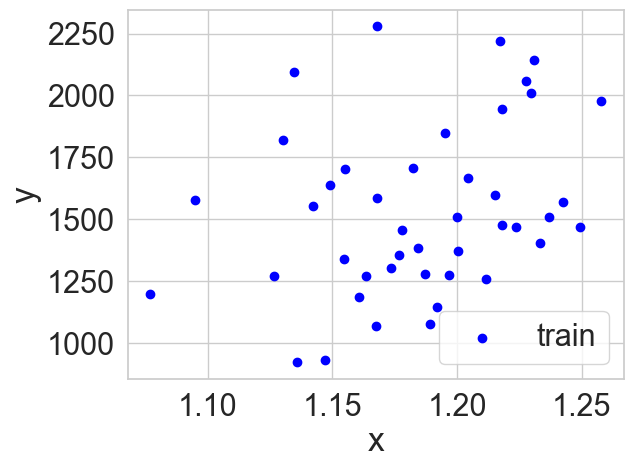

In [81]:
plt.scatter(x = x_train, y = t_train, c='blue', label='train')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Inicio con PCA para reducir la dimensionalidad de los datos.

In [82]:
# Ajustamos el estandarizador
std_scale.fit(X)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X)
# Ajustamos el estandarizador

std_scale.fit(X_test)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)

In [83]:
print(np.cov(X_scaled.T), np.cov(X_test_scaled.T) )

[[ 1.02380952  0.31239011  0.3348036  ...  0.20393843  0.19261573
   0.25947755]
 [ 0.31239011  1.02380952 -0.00618083 ...  0.2515454   0.24718953
   0.41106691]
 [ 0.3348036  -0.00618083  1.02380952 ...  0.22721804  0.26251115
   0.25146294]
 ...
 [ 0.20393843  0.2515454   0.22721804 ...  1.02380952  0.33749287
   0.84942995]
 [ 0.19261573  0.24718953  0.26251115 ...  0.33749287  1.02380952
   0.70781672]
 [ 0.25947755  0.41106691  0.25146294 ...  0.84942995  0.70781672
   1.02380952]] [[ 1.1        -0.33148649 -0.18854642 ...  0.14396696  0.37349082
   0.16076885]
 [-0.33148649  1.1         0.32721266 ... -0.24628684  0.13875358
  -0.17267431]
 [-0.18854642  0.32721266  1.1        ... -0.22271414  0.12053037
  -0.11563807]
 ...
 [ 0.14396696 -0.24628684 -0.22271414 ...  1.1         0.55789999
   1.05660679]
 [ 0.37349082  0.13875358  0.12053037 ...  0.55789999  1.1
   0.7468547 ]
 [ 0.16076885 -0.17267431 -0.11563807 ...  1.05660679  0.7468547
   1.1       ]]


In [87]:
# Busco una cantidad de componentes que me expliquen el 91% de la varianza y 
# usar descomposición de valor único (SVD) para calcular los vectores propios
pca = PCA(n_components=0.91, svd_solver='full')
# Ajustamos el modelo a los datos escaleados
pca.fit(X_scaled)

# Obtenemos la descripción de los datos en el espacio de componentes principales
X_pca = pca.transform(X_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_scaled.shape, X_pca.shape)

Dimensiones de la matriz en componentes principales: (43, 12)
(43, 290) (43, 12)


Text(0.5, 0, 'Cantidad de componentes principales')

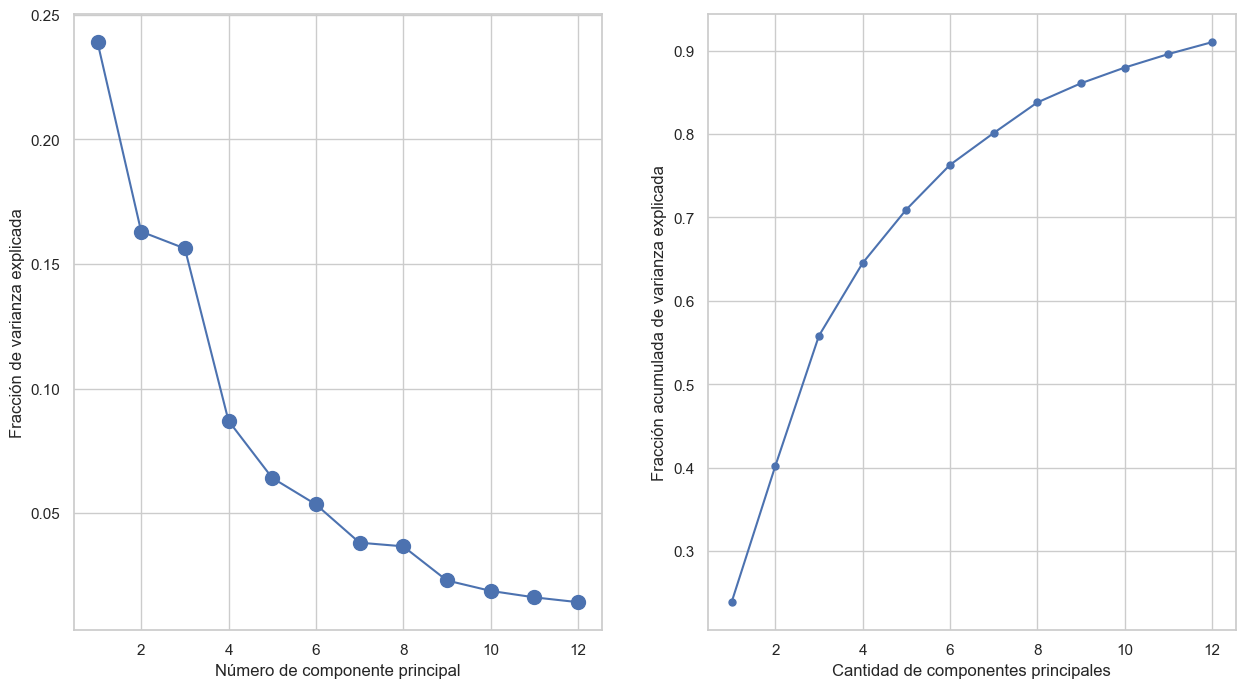

In [88]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 10)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

El gráfico de la izquierda nos dice qué fracción de información aporta cada componente. Lo que es importante notar es que cada componente aporta menos información que la anterior, por lo que las mismas están ordenadas de más a menos informativas. 

Quizás el gráfico de la derecha es más interesante: lo que nos dice es que tomando solamente las CINCO primeras componentes cubrimos el 70% de la información, con 7, un poco más del 80%, y así. Cuando tomamos tantas componentes como features en nuestro dataset original, no hay pérdida de información (esto simplemente se corresponde a un cambio de base del espacio de features al espacio de componentes principales).

### Interpretación de las primeras componentes

Una pregunta interesante que está bueno indagar es qué significan cada una de las componentes. Esta información esta contenida en la lista *.pca.components_* de nuestro modelo ya ajustado.

Veamos las primeras diez, que cubren el 90% de información de nuestros datos:

In [19]:
# obtenemos los features en el espacio de componentes principales
features = list(train_set.drop(['cod', 'label'], axis=1).columns)

In [20]:
# Agregamos la información de los componentes principales a un dataframe
df = pd.DataFrame(pca.components_, columns=features)

In [21]:
N_elements=6
loadings = pd.DataFrame(pca.components_[0:N_elements].T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=train_set.drop(['cod', 'label'], axis=1).columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
afsl_ad,-0.026600,0.059666,-0.062143,0.083463,0.060339,0.025454
afsl_area_of_end_region_1,-0.039128,0.052000,-0.043431,0.017928,0.022755,0.079414
afsl_area_of_end_region_2,-0.037340,0.056296,-0.042095,-0.002685,0.092629,-0.128892
afsl_branch_volume,0.038152,0.035984,0.068393,-0.009324,-0.111240,-0.046891
afsl_curl,0.028128,0.015604,0.013167,0.056603,-0.083081,0.117505
...,...,...,...,...,...,...
ufsr_total_area_of_end_regions,-0.068067,0.040016,-0.048040,-0.107299,0.027910,0.074595
ufsr_total_radius_of_end_regions,-0.013710,0.079326,0.104967,-0.000499,0.026260,0.062468
ufsr_total_surface_area,-0.045898,0.106275,0.035473,-0.055729,-0.016959,0.047413
ufsr_trunk_volume,-0.063283,0.017593,-0.079557,-0.081329,-0.072577,0.000439


In [22]:
N_elements=10

PC1=abs(pca.components_[1,:])
PC1.sort(axis=0)
PC1=PC1[::-1]
PC1=PC1[0:N_elements]
PC1

array([0.12134772, 0.12134772, 0.12134772, 0.12134772, 0.11998635,
       0.11708866, 0.11708866, 0.11708866, 0.11708866, 0.11359826])

In [23]:
pca.explained_variance_ratio_

array([0.23904073, 0.16300664, 0.15623072, 0.08704688, 0.06413833,
       0.05349901, 0.03814306, 0.0366694 , 0.02297678, 0.01879676,
       0.01619938, 0.01425875])

<Axes: >

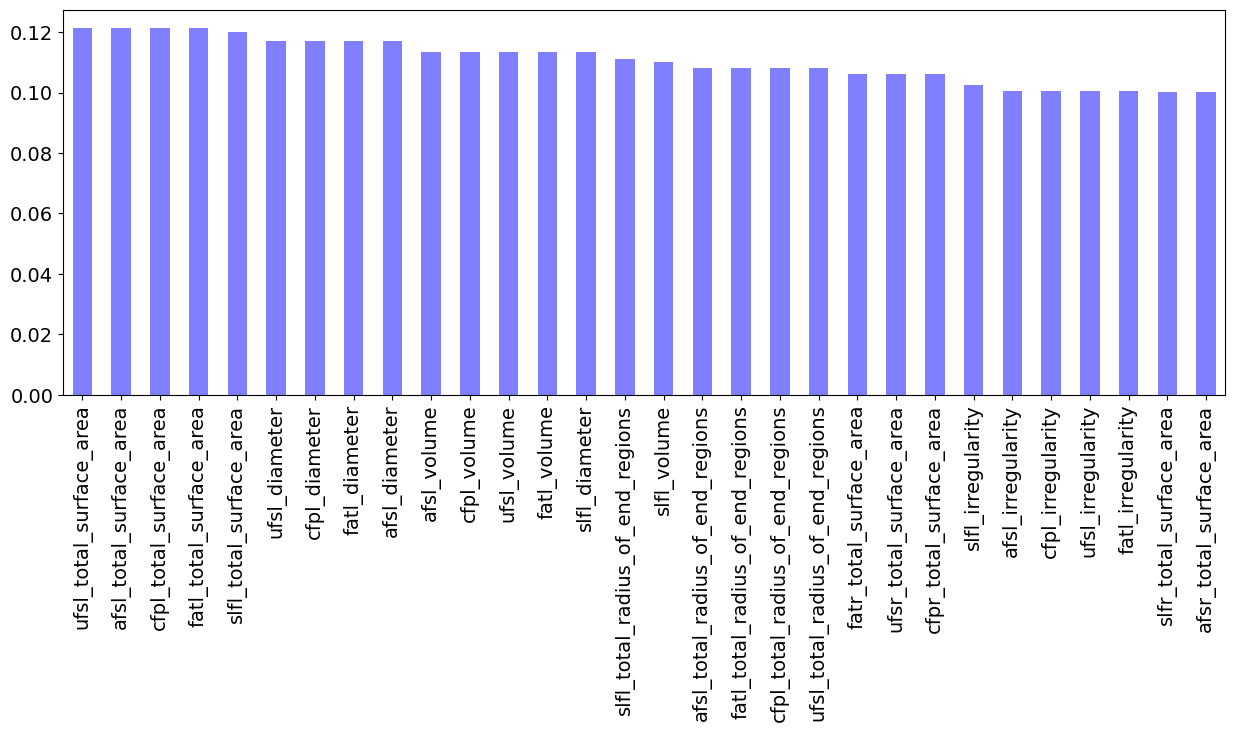

In [24]:
# tomo el primer registro de la matriz de features
N_elements=12
PC1=abs(df.loc[1,:])
PC1.sort_values(axis=0, ascending=False, inplace=True)
PC1[:30].plot(kind='bar', figsize=(15, 5), color='blue', alpha=0.5)

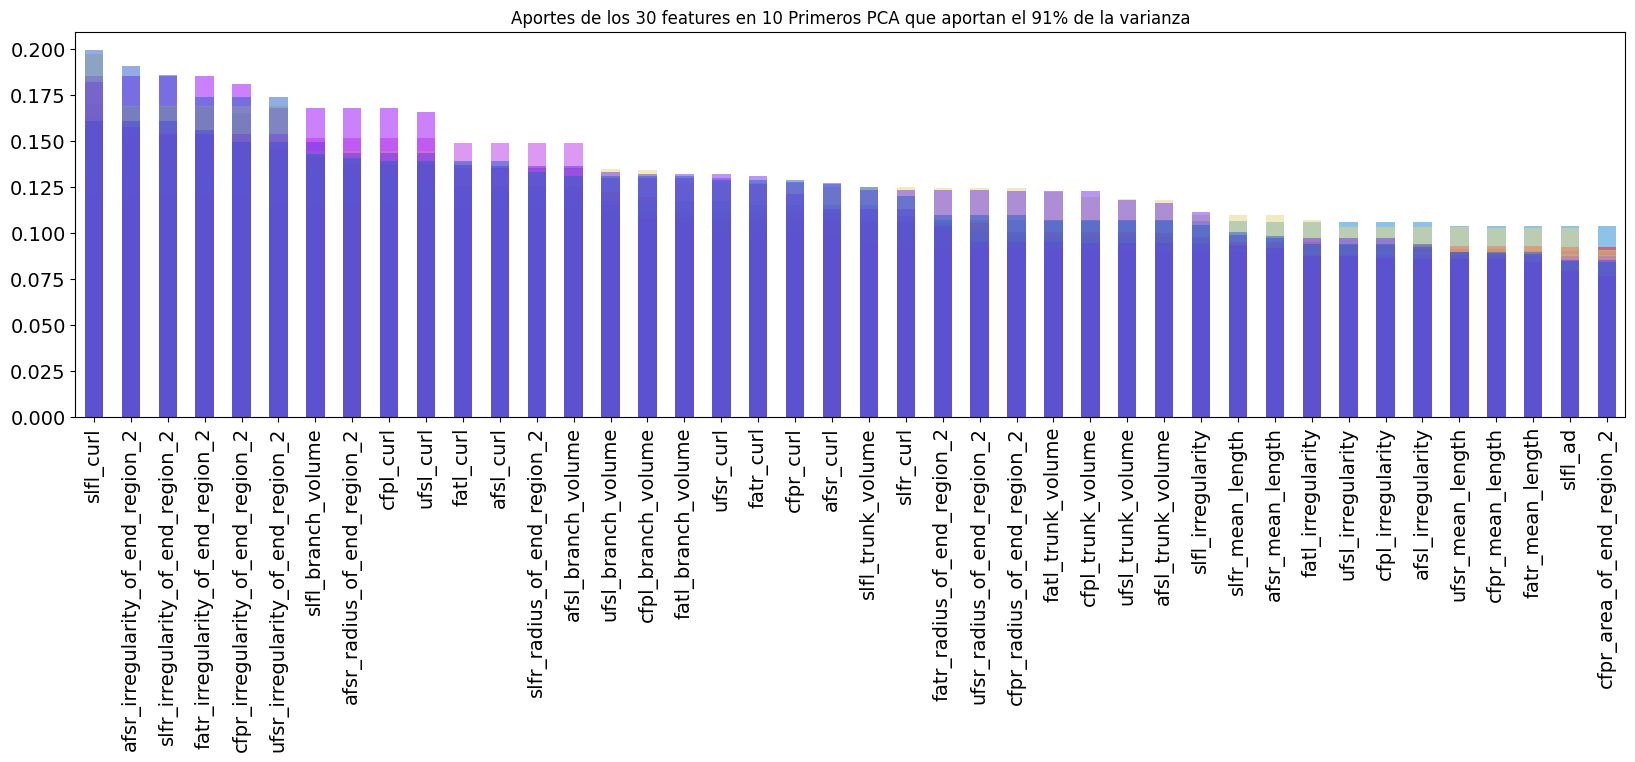

In [25]:
# Amado de gráfica con los 10 primeros features que aportan más a los 10 primeros componentes principales
import random
N_elements=42
lista = []
number_of_colors = 8
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(N_elements)]
for i in range(0,12):
    PC = abs(df.loc[i,:])
    PC.sort_values(axis=0, ascending=False, inplace=True)
    lista.append(PC[:N_elements])
    
    PC[:N_elements].plot(kind='bar', figsize=(20, 5), color=color[i], alpha=0.5,title='Aportes de los 30 features en 10 Primeros PCA que aportan el 91% de la varianza')



In [26]:
data = pd.DataFrame(lista).T
data.to_csv('../data/testdata.csv')

<Axes: >

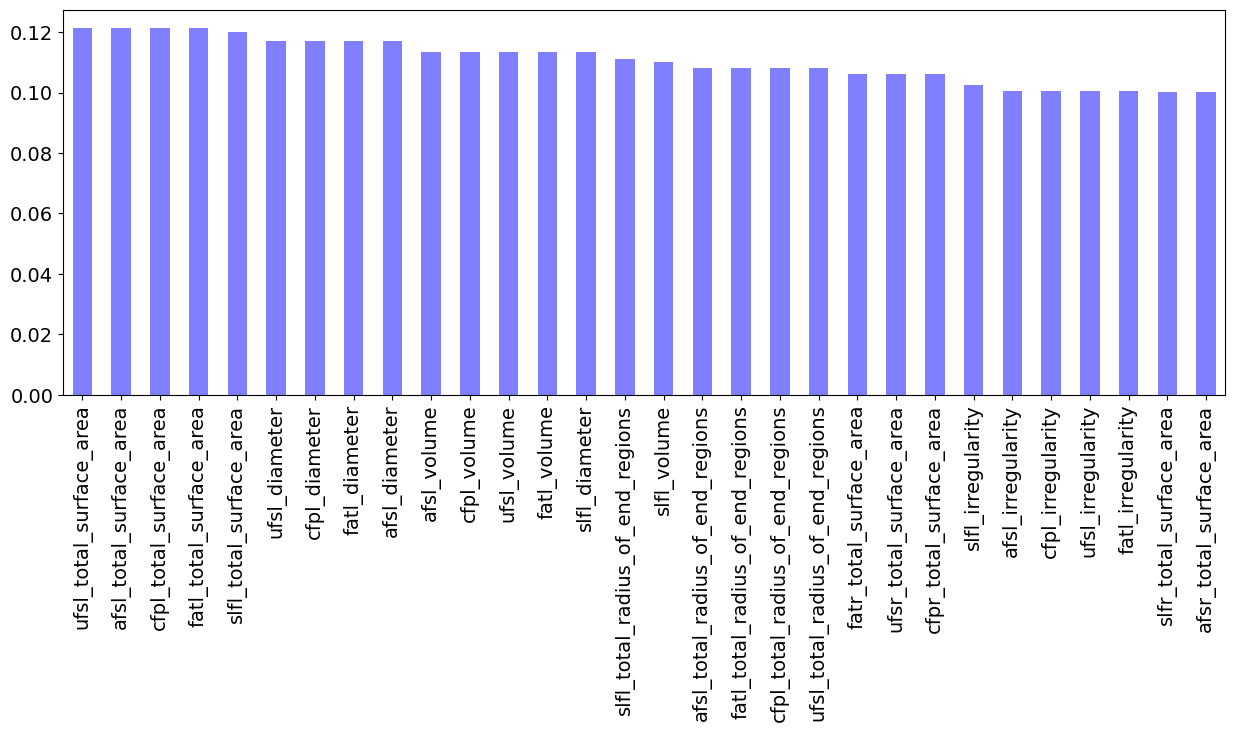

In [27]:
PC1=abs(df.loc[1,:])
PC1.sort_values(axis=0, ascending=False, inplace=True)
PC1[:30].plot(kind='bar', figsize=(15, 5), color='blue', alpha=0.5)

In [28]:
abs(pca.components_[1,:])

array([0.05966582, 0.05199968, 0.05629599, 0.03598429, 0.01560374,
       0.11708866, 0.01948974, 0.09148796, 0.10038698, 0.04691224,
       0.03731108, 0.0423435 , 0.05724201, 0.02201058, 0.04095102,
       0.04073623, 0.03955655, 0.04155436, 0.03929206, 0.06905739,
       0.0830699 , 0.0497693 , 0.04112707, 0.0019506 , 0.07591649,
       0.10813733, 0.12134772, 0.06055372, 0.11359826, 0.04791177,
       0.03816937, 0.00805592, 0.0540651 , 0.00701999, 0.07342322,
       0.01919828, 0.04611059, 0.08384814, 0.04169882, 0.03399652,
       0.04376096, 0.0456527 , 0.04643148, 0.04127983, 0.04114418,
       0.01497754, 0.02462397, 0.03919014, 0.08141754, 0.04017184,
       0.04083323, 0.0413907 , 0.01284933, 0.0337198 , 0.07347975,
       0.10024219, 0.01512354, 0.07686325, 0.05966582, 0.05199968,
       0.05629599, 0.03598429, 0.01560374, 0.11708866, 0.01948974,
       0.09148796, 0.10038698, 0.04691224, 0.03731108, 0.0423435 ,
       0.05724201, 0.02201058, 0.04095102, 0.04073623, 0.03955

In [29]:
PC1[::-1]

cfpl_span                  0.001951
ufsl_span                  0.001951
fatl_span                  0.001951
afsl_span                  0.001951
slfl_curl                  0.005052
                             ...   
slfl_total_surface_area    0.119986
fatl_total_surface_area    0.121348
cfpl_total_surface_area    0.121348
afsl_total_surface_area    0.121348
ufsl_total_surface_area    0.121348
Name: 1, Length: 290, dtype: float64

In [ ]:
# df.sort_values(by='x1', ascending=False)

In [ ]:
# Guardamos los componentes principales en un csv con sus respectivos nombres
# df.to_csv("../data/pca_components.csv", index=False)

In [31]:
# Matriz de features en el espacio de componentes principales
# Simplemente la matriz traspuesta de las componentes principales en el espacio de features
features_pc = pca.components_.T

print('Descripción de la variable afsl_ad en las componentes principales:')
print(features_pc[0])

Descripción de la variable afsl_ad en las componentes principales:
[-0.02659968  0.05966582 -0.06214281  0.08346304  0.06033855  0.02545387
 -0.0935821   0.06371017  0.07927754  0.04905516  0.04212453 -0.06515356]


Text(0, 0.5, 'Segunda componente principal')

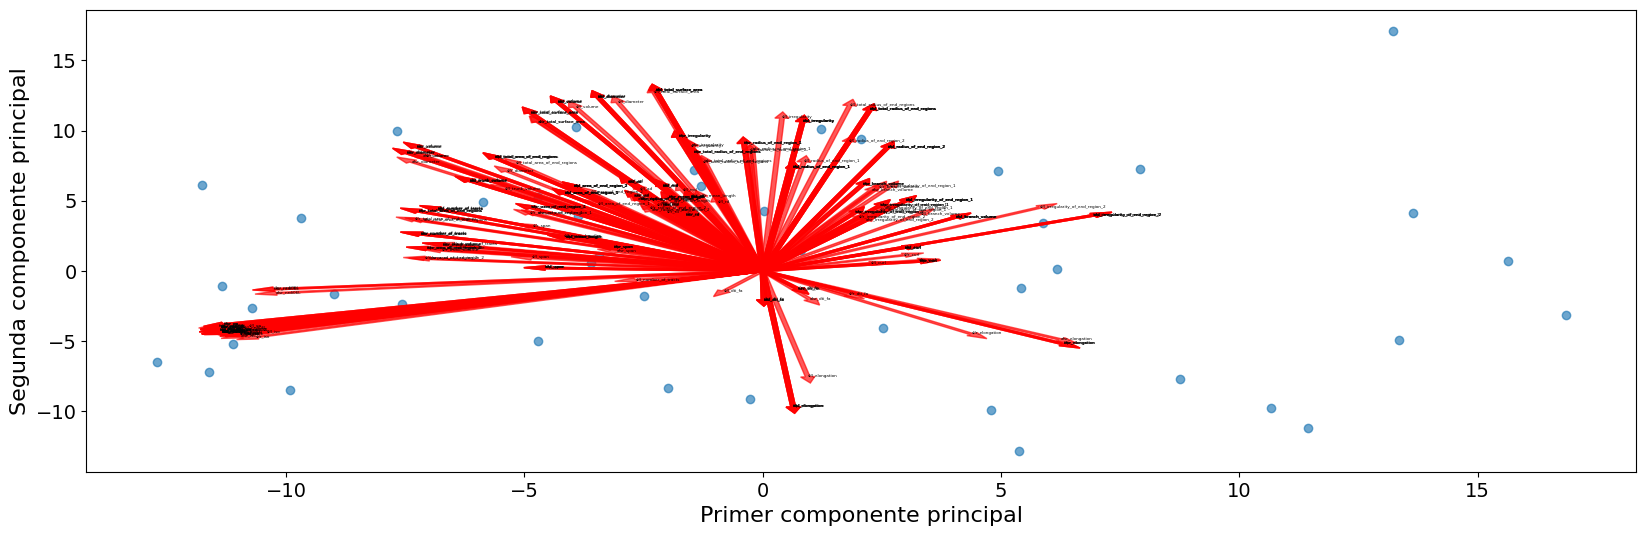

In [32]:
fig, ax = plt.subplots(figsize = (20, 6))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)

# Hacemos el grafico de las flechas indicando las direcciones de los features originales

sf = 106 # Factor de escala solo a efecto de estirar 
       # las flechas para que sean visibles (solo nos importa la dirección en realidad)

# Recorremos cada feature
for i in range(len(features)):

  # Creamos una flecha que vaya del origen y apunte en la dirección de los features
  ax.arrow(0, 0, sf * features_pc[i][0], sf * features_pc[i][1], width = 0.1, color = 'r', alpha = 0.65)

  # Indicamos con texto a qué feature corresponde cada flecha
  ax.text(sf * features_pc[i][0], sf * features_pc[i][1], s = features[i], fontdict= {'color': 'k', 'size': 3})

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

In [33]:
# ver la cantidad de información contenida en cada componente 
import numpy as np 

print(pca.explained_variance_ratio_)


[0.23904073 0.16300664 0.15623072 0.08704688 0.06413833 0.05349901
 0.03814306 0.0366694  0.02297678 0.01879676 0.01619938 0.01425875]


In [34]:
# calcular la información acumulada
print(pca.explained_variance_ratio_.cumsum())
print(pca.explained_variance_ratio_.cumsum()[0:12])


[0.23904073 0.40204737 0.55827809 0.64532497 0.7094633  0.76296231
 0.80110537 0.83777477 0.86075155 0.8795483  0.89574768 0.91000642]
[0.23904073 0.40204737 0.55827809 0.64532497 0.7094633  0.76296231
 0.80110537 0.83777477 0.86075155 0.8795483  0.89574768 0.91000642]


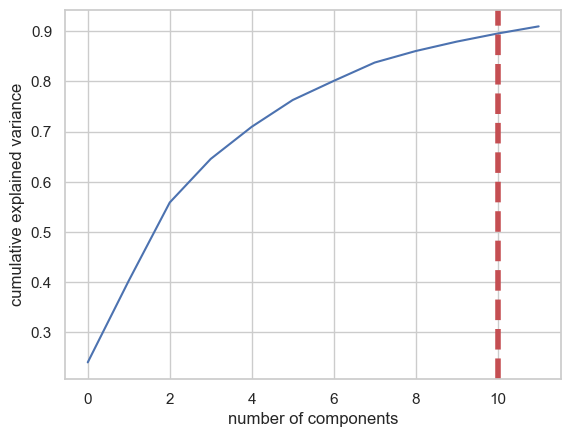

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.239041,0.239041
1,0.402047,0.163007
2,0.558278,0.156231
3,0.645325,0.087047
4,0.709463,0.064138
5,0.762962,0.053499
6,0.801105,0.038143
7,0.837775,0.036669
8,0.860752,0.022977
9,0.879548,0.018797


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_test = PCA(n_components=0.91, svd_solver='full')
pca_test.fit(X_scaled)
X_train_scaled_pca = pca.transform(X_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [98]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_scaled, y)
display(rfc.score(X_scaled, y))

1.0

In [91]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y)
rs.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 18,
 'min_samples_leaf': 39,
 'max_features': 'log2',
 'max_depth': 2,
 'bootstrap': True}

In [92]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,300,18,39,log2,2,True,0.698413,1
1,600,2,34,sqrt,12,True,0.698413,1
2,100,2,18,sqrt,15,False,0.698413,1
3,300,28,39,log2,14,True,0.698413,1
4,700,18,7,sqrt,7,False,0.698413,1
5,700,23,7,log2,15,False,0.698413,1
6,500,12,18,sqrt,13,False,0.698413,1
7,200,50,28,sqrt,9,True,0.698413,1
8,100,50,44,sqrt,7,False,0.698413,1
9,400,12,39,sqrt,6,True,0.698413,1


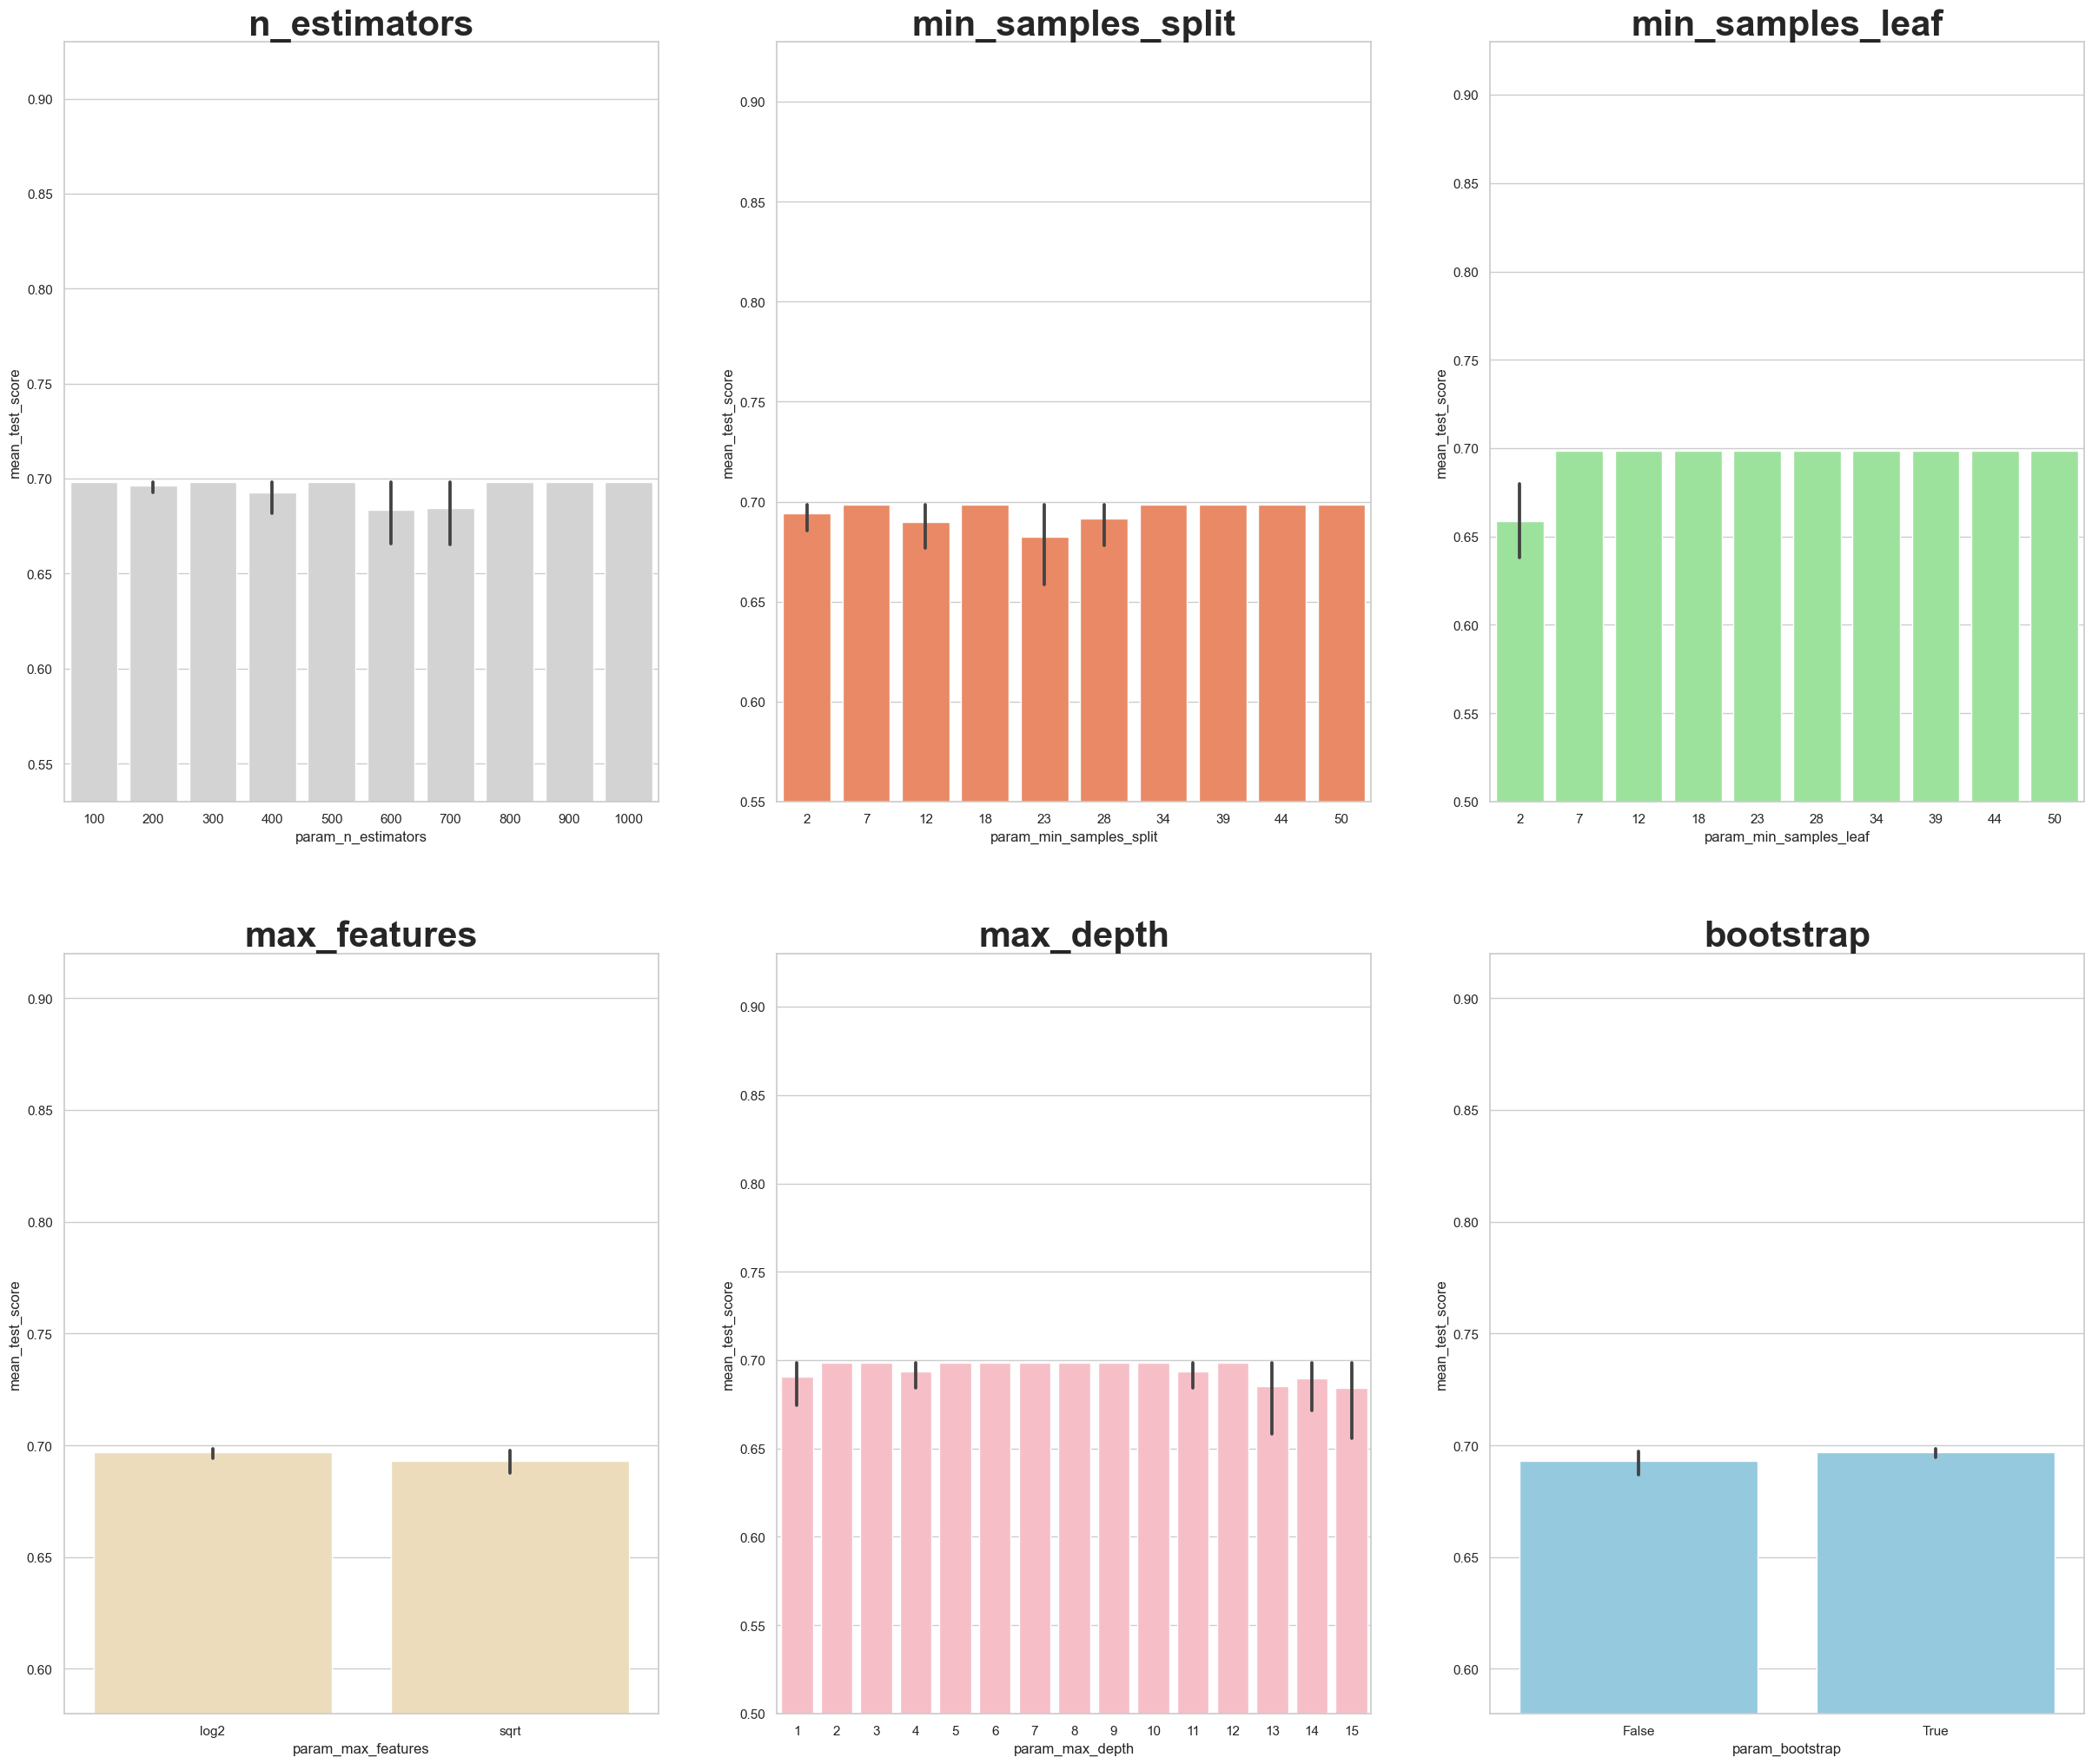

In [93]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.53,.93]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.55,.93]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.50,.93]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.58,.92]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.50,.93]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.58,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [94]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y)
rfc_3 = gs.best_estimator_
gs.best_params_


Fitting 3 folds for each of 540 candidates, totalling 1620 fits


{'bootstrap': False,
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 22,
 'n_estimators': 300}

In [ ]:
rfc1 = RandomForestClassifier()
rfc1.fit(X_scaled, y)
display(rfc.score(X_scaled, y))

In [111]:
rfc.fit(X_train_scaled_pca, y)
display(rfc.score(X_train_scaled_pca, y))

1.0

In [ ]:
y_pred = rfc1.predict(X_test_scaled)
y_pred_pca = rfc1.predict(X_test_scaled_pca)
y_pred_gs = gs.predict(X_test_scaled_pca)

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
#conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))
#display(conf_matrix_baseline_pca)
display('Baseline Random Forest With PCA recall score', recall_score(y, y_pred_pca))
display(conf_matrix_tuned_pca)
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test, y_pred_gs))